# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [69]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [ ]:
# Load train and test data
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

Due to the huge size of data, analysing the data is very time consuming. As such I started looking for solution online. I found a nice article "[How to handle BigData Files on Low Memory?](https://towardsdatascience.com/how-to-learn-from-bigdata-files-on-low-memory-incremental-learning-d377282d38ff#e618)"

###### Memory Reduction

In [ ]:
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df

In [ ]:
azdias_reduce = reduce_mem_usage(azdias)

In [ ]:
customers_reduce = reduce_mem_usage(customers)

In [ ]:
mailout_train_reduce = reduce_mem_usage(mailout_train)

In [ ]:
mailout_test_reduce = reduce_mem_usage(mailout_test)

I decided to save the files as it is faster to load than the original 

In [ ]:
azdias_reduce.to_csv('Udacity_AZDIAS_reduce_mem_052018.csv')

In [ ]:
customers_reduce.to_csv('Udacity_CUSTOMERS_reduce_mem_052018.csv')

In [ ]:
mailout_train_reduce.to_csv('Udacity_MAILOUT_052018_TRAIN_reduce_mem.csv')

In [ ]:
mailout_test_reduce.to_csv('Udacity_MAILOUT_052018_TEST_reduce_mem.csv')

### Load Memory reduction data

In [2]:
# Read data with after memory reduction
azdias = pd.read_csv('Udacity_AZDIAS_reduce_mem_052018.csv')
customers = pd.read_csv('Udacity_CUSTOMERS_reduce_mem_052018.csv')

#Load train and test data after memory reduction
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN_reduce_mem.csv')
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST_reduce_mem.csv')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.shape

(891221, 367)

In [4]:
azdias.describe()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,891221.000000,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,445610.000000,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,257273.486466,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,0.000000,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,222805.000000,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,445610.000000,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,668415.000000,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,891220.000000,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [5]:
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 367 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 2.4+ GB


In [7]:
customers.shape

(191652, 370)

In [8]:
customers.describe()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95825.500000,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,0.000000,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47912.750000,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95825.500000,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143738.250000,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191651.000000,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [9]:
customers.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 370 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(95), object(8)
memory usage: 541.0+ MB


In [11]:
mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [12]:
mailout_test.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [13]:
# Read information on the attributes 
# top-level list of attributes and descriptions, organized by informational category
attributes_des = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
# Detailed mapping of data values for each feature in alphabetical order
attributes_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')

In [14]:
attributes_info.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [15]:
attributes_des.head(10)

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [16]:
# Let's drop unnecessary columns
del attributes_info['Unnamed: 0']
del attributes_des['Unnamed: 0']

#### Investigate warning messages 

In [17]:
azdias.columns[18:20]

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015'], dtype='object')

In [31]:
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

In [32]:
azdias['CAMEO_DEU_2015'].value_counts()

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
Name: CAMEO_DEU_2015, dtype: int64

In [33]:
azdias.drop('CAMEO_DEU_2015',inplace=True,axis=1)

In [34]:
azdias['CAMEO_DEUG_2015'].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1'], dtype=object)

In [35]:
azdias['CAMEO_DEUG_2015'].value_counts()


8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
Name: CAMEO_DEUG_2015, dtype: int64

In [36]:
# Replaces suspicious data with NULL values.
azdias[['CAMEO_DEUG_2015']] = azdias[['CAMEO_DEUG_2015']].replace(['X'],np.NaN)
azdias[['CAMEO_DEUG_2015']] = azdias[['CAMEO_DEUG_2015']].replace(['XX','X'],np.NaN)

In [38]:
azdias['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
Name: CAMEO_DEUG_2015, dtype: int64

In [39]:
attributes_info[attributes_info["Attribute"] == "CAMEO_DEUG_2015"]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown


In [40]:
# Forward fill missing value
attributes_info.ffill(inplace=True)

In [41]:
attributes_info

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


Find the features that is in Azdias but not in attributes_val, features that we don't have information about

In [42]:
# Features we have information
attributes_list = attributes_info['Attribute'].unique()
print(len(attributes_list))
print(attributes_list)

314
['AGER_TYP' 'ALTERSKATEGORIE_GROB' 'ALTER_HH' 'ANREDE_KZ'
 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'ANZ_PERSONEN' 'ANZ_TITEL' 'BALLRAUM'
 'BIP_FLAG' 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015' 'CAMEO_DEUINTL_2015'
 'CJT_GESAMTTYP' 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24' 'D19_BANKEN_DATUM'
 'D19_BANKEN_DIREKT_RZ' 'D19_BANKEN_GROSS_RZ' 'D19_BANKEN_LOKAL_RZ'
 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_BANKEN_REST_RZ' 'D19_BEKLEIDUNG_GEH_RZ'
 'D19_BEKLEIDUNG_REST_RZ' 'D19_BILDUNG_RZ' 'D19_BIO_OEKO_RZ' 'D19_BUCH_RZ'
 'D19_DIGIT_SERV_RZ' 'D19_DROGERIEARTIKEL_RZ' 'D19_ENERGIE_RZ'
 'D19_FREIZEIT_RZ' 'D19_GARTEN_RZ' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24'
 'D19_GESAMT_DATUM' 'D19_GESAMT_OFFLINE_DATUM' 'D19_GESAMT_ONLINE_DATUM'
 'D19_GESAMT_ONLINE_QUOTE_12' 'D19_HANDWERK_RZ' 'D19_HAUS_DEKO_RZ'
 'D19_KINDERARTIKEL_RZ' 'D19_KONSUMTYP' 'D19_KK_KUNDENTYP'
 'D19_KOSMETIK_RZ' 'D19_LEBENSMITTEL_RZ' 'D19_LOTTO_RZ'
 'D19_NAHRUNGSERGAENZUNG_RZ' 'D19_RATGEBER_RZ' 'D19_R

In [43]:
# features with information but not in azdias
feat_not_azdias = list(set(attributes_list) - set(azdias))
print(len(feat_not_azdias))
print(feat_not_azdias)

43
['D19_BIO_OEKO_RZ', 'BIP_FLAG', 'WACHSTUMSGEBIET_NB', 'D19_DROGERIEARTIKEL_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_VERSAND_REST_RZ', 'D19_TELKO_REST_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ', 'CAMEO_DEU_2015', 'D19_KK_KUNDENTYP', 'D19_BANKEN_DIREKT_RZ', 'D19_WEIN_FEINKOST_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'SOHO_FLAG', 'D19_BANKEN_REST_RZ', 'D19_RATGEBER_RZ', 'D19_KOSMETIK_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_FREIZEIT_RZ', 'D19_TECHNIK_RZ', 'D19_BILDUNG_RZ', 'D19_SCHUHE_RZ', 'D19_TIERARTIKEL_RZ', 'D19_HANDWERK_RZ', 'D19_TELKO_MOBILE_RZ', 'D19_REISEN_RZ', 'HAUSHALTSSTRUKTUR', 'D19_VOLLSORTIMENT_RZ', 'D19_LOTTO_RZ', 'D19_ENERGIE_RZ', 'D19_DIGIT_SERV_RZ', 'CAMEO_DEUINTL_2015', 'D19_GARTEN_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_VERSICHERUNGEN_RZ', 'D19_BANKEN_GROSS_RZ', 'D19_HAUS_DEKO_RZ', 'D19_SAMMELARTIKEL_RZ', 'D19_SONSTIGE_RZ', 'D19_BUCH_RZ', 'KBA13_CCM_1400_2500', 'GEOSCORE_KLS7']


In [44]:
# features in azdias that we don't have information
feat_no_info = list(set(azdias) - set(attributes_list))
print(feat_no_info)
len(feat_no_info)

['KBA13_KMH_210', 'MOBI_RASTER', 'D19_BANKEN_DIREKT', 'D19_ENERGIE', 'D19_LETZTER_KAUF_BRANCHE', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSAND_REST', 'D19_KOSMETIK', 'CJT_TYP_3', 'LNR', 'D19_LEBENSMITTEL', 'D19_REISEN', 'D19_TECHNIK', 'KONSUMZELLE', 'DSL_FLAG', 'D19_LOTTO', 'D19_BEKLEIDUNG_GEH', 'HH_DELTA_FLAG', 'D19_HANDWERK', 'D19_BANKEN_REST', 'D19_KINDERARTIKEL', 'ANZ_STATISTISCHE_HAUSHALTE', 'KK_KUNDENTYP', 'D19_FREIZEIT', 'D19_SOZIALES', 'KBA13_ANTG2', 'EINGEFUEGT_AM', 'ALTER_KIND1', 'CJT_TYP_6', 'RT_UEBERGROESSE', 'KBA13_ANTG1', 'AKT_DAT_KL', 'D19_KONSUMTYP_MAX', 'D19_VERSICHERUNGEN', 'D19_VERSI_ONLINE_DATUM', 'VK_ZG11', 'UNGLEICHENN_FLAG', 'D19_BUCH_CD', 'VK_DISTANZ', 'KBA13_ANTG4', 'CJT_KATALOGNUTZER', 'D19_RATGEBER', 'CJT_TYP_1', 'KBA13_HHZ', 'ALTER_KIND4', 'D19_TELKO_MOBILE', 'KBA13_ANTG3', 'D19_BEKLEIDUNG_REST', 'VERDICHTUNGSRAUM', 'RT_SCHNAEPPCHEN', 'D19_SCHUHE', 'SOHO_KZ', 'D19_BANKEN_LOKAL', 'GEMEINDETYP', 'D19_BIO_OEKO', 'ALTERSKATEGORIE_FEIN', 'D19_VOLLSORTIMENT', 'CJT_TYP

95

In [45]:
feat_no_info_df = pd.DataFrame(feat_no_info)
feat_no_info_df

,0
0,KBA13_KMH_210
1,MOBI_RASTER
2,D19_BANKEN_DIREKT
3,D19_ENERGIE
4,D19_LETZTER_KAUF_BRANCHE
5,D19_VERSI_ONLINE_QUOTE_12
6,D19_VERSAND_REST
7,D19_KOSMETIK
8,CJT_TYP_3
9,LNR


In [46]:
feat_not_azdias_df = pd.DataFrame(feat_not_azdias)
feat_not_azdias_df

,0
0,D19_BIO_OEKO_RZ
1,BIP_FLAG
2,WACHSTUMSGEBIET_NB
3,D19_DROGERIEARTIKEL_RZ
4,D19_LEBENSMITTEL_RZ
5,D19_VERSAND_REST_RZ
6,D19_TELKO_REST_RZ
7,D19_NAHRUNGSERGAENZUNG_RZ
8,CAMEO_DEU_2015
9,D19_KK_KUNDENTYP


In [47]:
missing_info = [feat_no_info_df,feat_not_azdias_df]
missing_info_merge = pd.concat(missing_info,  axis=1, join='inner')
missing_info_merge

,0,0
0,KBA13_KMH_210,D19_BIO_OEKO_RZ
1,MOBI_RASTER,BIP_FLAG
2,D19_BANKEN_DIREKT,WACHSTUMSGEBIET_NB
3,D19_ENERGIE,D19_DROGERIEARTIKEL_RZ
4,D19_LETZTER_KAUF_BRANCHE,D19_LEBENSMITTEL_RZ
5,D19_VERSI_ONLINE_QUOTE_12,D19_VERSAND_REST_RZ
6,D19_VERSAND_REST,D19_TELKO_REST_RZ
7,D19_KOSMETIK,D19_NAHRUNGSERGAENZUNG_RZ
8,CJT_TYP_3,CAMEO_DEU_2015
9,LNR,D19_KK_KUNDENTYP


In [49]:
missing_info_merge.to_excel("missing_info.xlsx")

In [50]:
feat_no_info_df.to_excel("no_info.xlsx")  

In [51]:
missing_info_merge

,0,0
0,KBA13_KMH_210,D19_BIO_OEKO_RZ
1,MOBI_RASTER,BIP_FLAG
2,D19_BANKEN_DIREKT,WACHSTUMSGEBIET_NB
3,D19_ENERGIE,D19_DROGERIEARTIKEL_RZ
4,D19_LETZTER_KAUF_BRANCHE,D19_LEBENSMITTEL_RZ
5,D19_VERSI_ONLINE_QUOTE_12,D19_VERSAND_REST_RZ
6,D19_VERSAND_REST,D19_TELKO_REST_RZ
7,D19_KOSMETIK,D19_NAHRUNGSERGAENZUNG_RZ
8,CJT_TYP_3,CAMEO_DEU_2015
9,LNR,D19_KK_KUNDENTYP


##### Further investigation of features without information before deleting

In [52]:
azdias['D19_BEKLEIDUNG_REST']

0         0
1         0
2         0
3         0
4         1
5         0
6         0
7         0
8         0
9         6
10        0
11        0
12        6
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        6
24        0
25        0
26        0
27        7
28        0
29        6
         ..
891191    0
891192    0
891193    0
891194    6
891195    0
891196    6
891197    0
891198    0
891199    0
891200    0
891201    5
891202    0
891203    0
891204    0
891205    0
891206    0
891207    0
891208    0
891209    0
891210    0
891211    0
891212    0
891213    2
891214    0
891215    0
891216    5
891217    0
891218    6
891219    0
891220    0
Name: D19_BEKLEIDUNG_REST, Length: 891221, dtype: int64

In [53]:
azdias['D19_BEKLEIDUNG_REST'].describe()

count    891221.000000
mean          1.145516
std           2.266999
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: D19_BEKLEIDUNG_REST, dtype: float64

In [54]:
attributes_info.loc[attributes_info['Attribute'] == 'D19_BEKLEIDUNG_REST_RZ']


,Attribute,Description,Value,Meaning
233,D19_BEKLEIDUNG_REST_RZ,transactional activity based on the product gr...,0,no transaction known
234,D19_BEKLEIDUNG_REST_RZ,- on grid level -,1,Multibuyer 0-12 months
235,D19_BEKLEIDUNG_REST_RZ,- on grid level -,2,Doublebuyer 0-12 months
236,D19_BEKLEIDUNG_REST_RZ,- on grid level -,3,Singlebuyer 0-12 months
237,D19_BEKLEIDUNG_REST_RZ,- on grid level -,4,Multi-/Doublebuyer 13-24 months
238,D19_BEKLEIDUNG_REST_RZ,- on grid level -,5,Singlebuyer 13-24 months
239,D19_BEKLEIDUNG_REST_RZ,- on grid level -,6,Buyer > 24 months
240,D19_BEKLEIDUNG_REST_RZ,- on grid level -,7,Prospects > 24 months


In [55]:
attributes_info.loc[attributes_info['Attribute'] == 'D19_BANKEN_REST_RZ']


,Attribute,Description,Value,Meaning
217,D19_BANKEN_REST_RZ,transactional activity based on the product gr...,0,no transaction known
218,D19_BANKEN_REST_RZ,- on grid level -,1,Multibuyer 0-12 months
219,D19_BANKEN_REST_RZ,- on grid level -,2,Doublebuyer 0-12 months
220,D19_BANKEN_REST_RZ,- on grid level -,3,Singlebuyer 0-12 months
221,D19_BANKEN_REST_RZ,- on grid level -,4,Multi-/Doublebuyer 13-24 months
222,D19_BANKEN_REST_RZ,- on grid level -,5,Singlebuyer 13-24 months
223,D19_BANKEN_REST_RZ,- on grid level -,6,Buyer > 24 months
224,D19_BANKEN_REST_RZ,- on grid level -,7,Prospects > 24 months


In [56]:
azdias['D19_BANKEN_REST'].describe()

count    891221.000000
mean          0.425645
std           1.510782
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: D19_BANKEN_REST, dtype: float64

In [57]:
features_to_drop = pd.read_excel('missing_info_drop.xlsx', sep=';')

In [58]:
dropping_list = features_to_drop['drop'].unique()
dropping_list = list(set(dropping_list))
print(len(dropping_list))
print(dropping_list)

28
['D19_VERSI_DATUM', 'KBA13_ANTG3', nan, 'KBA13_KMH_210', 'VERDICHTUNGSRAUM', 'ARBEIT', 'MOBI_RASTER', 'ANZ_STATISTISCHE_HAUSHALTE', 'KK_KUNDENTYP', 'CJT_TYP_6', 'VHN', 'D19_VERSI_ONLINE_QUOTE_12', 'ALTER_KIND3', 'D19_KONSUMTYP_MAX', 'D19_VERSI_ONLINE_DATUM', 'CJT_TYP_3', 'LNR', 'D19_VERSI_OFFLINE_DATUM', 'EINGEZOGENAM_HH_JAHR', 'VK_DHT4A', 'KBA13_BAUMAX', 'KBA13_GBZ', 'KBA13_ANTG4', 'FIRMENDICHTE', 'KBA13_HHZ', 'KOMBIALTER', 'D19_TELKO_MOBILE', 'UMFELD_ALT']


Drop the features in dropping_list as we don't have any information about them

In [60]:
azdias.drop(['KBA13_GBZ', 'VHN', 'D19_VERSI_ONLINE_QUOTE_12', 'KBA13_BAUMAX', 'D19_KONSUMTYP_MAX', 'D19_VERSI_DATUM', 
             'ALTER_KIND3', 'D19_VERSI_OFFLINE_DATUM', 'CJT_TYP_6', 'VERDICHTUNGSRAUM', 'KK_KUNDENTYP', 'KBA13_HHZ', 
             'D19_TELKO_MOBILE', 'MOBI_RASTER', 'D19_VERSI_ONLINE_DATUM', 'LNR', 'ANZ_STATISTISCHE_HAUSHALTE', 
             'EINGEZOGENAM_HH_JAHR', 'KBA13_ANTG4', 'UMFELD_ALT', 'KOMBIALTER', 'ARBEIT', 'KBA13_ANTG3', 'VK_DHT4A', 
             'CJT_TYP_3', 'FIRMENDICHTE', 'KBA13_KMH_210'],axis=1,inplace=True)

In [61]:
customers.drop(['KBA13_GBZ', 'VHN', 'D19_VERSI_ONLINE_QUOTE_12', 'KBA13_BAUMAX', 'D19_KONSUMTYP_MAX', 'D19_VERSI_DATUM', 
                'ALTER_KIND3', 'D19_VERSI_OFFLINE_DATUM', 'CJT_TYP_6', 'VERDICHTUNGSRAUM', 'KK_KUNDENTYP', 'KBA13_HHZ', 
                'D19_TELKO_MOBILE', 'MOBI_RASTER', 'D19_VERSI_ONLINE_DATUM', 'LNR', 'ANZ_STATISTISCHE_HAUSHALTE', 
                'EINGEZOGENAM_HH_JAHR', 'KBA13_ANTG4', 'UMFELD_ALT', 'KOMBIALTER', 'ARBEIT', 'KBA13_ANTG3', 'VK_DHT4A', 
                'CJT_TYP_3', 'FIRMENDICHTE', 'KBA13_KMH_210'],axis=1,inplace=True)

##### Look at the extra columnns in customers

In [62]:
customers['PRODUCT_GROUP'].unique()

array(['COSMETIC_AND_FOOD', 'FOOD', 'COSMETIC'], dtype=object)

In [63]:
customers['ONLINE_PURCHASE'].describe()

count    191652.000000
mean          0.090247
std           0.286536
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ONLINE_PURCHASE, dtype: float64

In [64]:
customers['CUSTOMER_GROUP'].unique()

array(['MULTI_BUYER', 'SINGLE_BUYER'], dtype=object)

In [65]:
customers.drop(['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP'],axis=1,inplace=True)

#### Looking at the missing values/ nan

Text(0.5,0,'prop. of missing values')

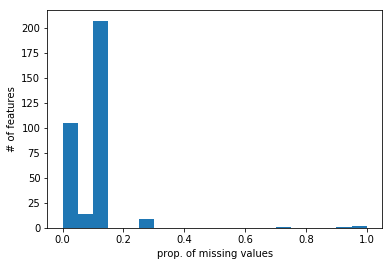

In [66]:
# Investigate nan values
features_nans = azdias.isnull().mean()
plt.hist(features_nans, bins = np.arange(0,1+.05,.05))
plt.ylabel('# of features')
plt.xlabel('prop. of missing values')

In [67]:
# Shows unknown or missing values for specific attribute
unknowns = []
for attribute in attributes_info['Attribute'].unique():
    _ = attributes_info.loc[attributes_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    _ = _.split(',')
    unknowns.append(_)
    
unknowns = pd.concat([pd.Series(attributes_info['Attribute'].unique()), pd.Series(unknowns)], axis=1)
unknowns.columns = ['attribute', 'missing_or_unknown']
print(unknowns)

                      attribute  \
0                      AGER_TYP   
1          ALTERSKATEGORIE_GROB   
2                      ALTER_HH   
3                     ANREDE_KZ   
4           ANZ_HAUSHALTE_AKTIV   
5                  ANZ_HH_TITEL   
6                  ANZ_PERSONEN   
7                     ANZ_TITEL   
8                      BALLRAUM   
9                      BIP_FLAG   
10              CAMEO_DEUG_2015   
11               CAMEO_DEU_2015   
12           CAMEO_DEUINTL_2015   
13                CJT_GESAMTTYP   
14            D19_BANKEN_ANZ_12   
15            D19_BANKEN_ANZ_24   
16             D19_BANKEN_DATUM   
17         D19_BANKEN_DIREKT_RZ   
18          D19_BANKEN_GROSS_RZ   
19          D19_BANKEN_LOKAL_RZ   
20     D19_BANKEN_OFFLINE_DATUM   
21      D19_BANKEN_ONLINE_DATUM   
22   D19_BANKEN_ONLINE_QUOTE_12   
23           D19_BANKEN_REST_RZ   
24        D19_BEKLEIDUNG_GEH_RZ   
25       D19_BEKLEIDUNG_REST_RZ   
26               D19_BILDUNG_RZ   
27              D19_

In [70]:
# Shows unknown value for a specific attribute
start = time.time()
    
for row in unknowns['attribute']:
    print(row)
    if row in azdias.columns:
        na_map = unknowns.loc[unknowns['attribute'] == row, 'missing_or_unknown'].iloc[0]
        na_indx = azdias.loc[:, row].isin(na_map)
        azdias.loc[na_indx, row] = np.NaN
    else:
        continue

end = time.time()
elapsed = end - start
elapsed

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_PERSONEN
ANZ_TITEL
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT_RZ
D19_BANKEN_GROSS_RZ
D19_BANKEN_LOKAL_RZ
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST_RZ
D19_BEKLEIDUNG_GEH_RZ
D19_BEKLEIDUNG_REST_RZ
D19_BILDUNG_RZ
D19_BIO_OEKO_RZ
D19_BUCH_RZ
D19_DIGIT_SERV_RZ
D19_DROGERIEARTIKEL_RZ
D19_ENERGIE_RZ
D19_FREIZEIT_RZ
D19_GARTEN_RZ
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK_RZ
D19_HAUS_DEKO_RZ
D19_KINDERARTIKEL_RZ
D19_KONSUMTYP
D19_KK_KUNDENTYP
D19_KOSMETIK_RZ
D19_LEBENSMITTEL_RZ
D19_LOTTO_RZ
D19_NAHRUNGSERGAENZUNG_RZ
D19_RATGEBER_RZ
D19_REISEN_RZ
D19_SAMMELARTIKEL_RZ
D19_SCHUHE_RZ
D19_SONSTIGE_RZ
D19_TECHNIK_RZ
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_D

10135.69339132309

Text(0.5,0,'prop. of missing values')

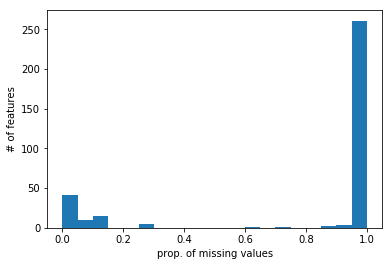

In [71]:
column_nans = azdias.isnull().mean()
plt.hist(column_nans, bins = np.arange(0,1+.05,.05))
plt.ylabel('# of features')
plt.xlabel('prop. of missing values')

In [72]:
# colums with more than 20% of missing values
col_drops = column_nans[columns_nans>0.2].index

NameError: name 'columns_nans' is not defined

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')